# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float32) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float32) / 255.0
    
#     Substract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat

train_X, train_y, test_X, test_y = \
load_svhn("/home/artem/dlcourse_ai/assignments/assignment1/data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ], np.float)

# layer = ReLULayer()
# layer.forward(X)

assert check_layer_gradient(ReLULayer(), X)

аналитический градиент
1.6159940625632276
численный градиент
1.6159940625648515
------------------------------------
аналитический градиент
0.0
численный градиент
0.0
------------------------------------
аналитический градиент
2.7625252407895857
численный градиент
2.7625252407403873
------------------------------------
аналитический градиент
0.0
численный градиент
0.0
------------------------------------
аналитический градиент
-0.5060347044691067
численный градиент
-0.506034704450542
------------------------------------
аналитический градиент
-0.9430251923423104
численный градиент
-0.9430251923348009
------------------------------------
Gradient check passed!


/tmp/ipykernel_34560/41734582.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ], np.float)


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
X = np.random.rand(3,4)
# batch_size
print(X)
layer = FullyConnectedLayer(4, 1)
layer.forward(X)

[[0.44022173 0.83320969 0.92940757 0.62842283]
 [0.39494519 0.25403102 0.98213518 0.98302   ]
 [0.92497695 0.78566915 0.32577954 0.81700048]]


array([[-0.00173823],
       [-0.00109404],
       [-0.00232179]])

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(4, 2), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(4, 1), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(4, 2), X, 'B')

аналитический градиент
-0.002010561786481279
численный градиент
-0.002010561786459572
------------------------------------
аналитический градиент
-0.000446208266911871
численный градиент
-0.00044620826686325715
------------------------------------
аналитический градиент
-0.0031212223558548828
численный градиент
-0.0031212223558334247
------------------------------------
аналитический градиент
-0.00024731904740710853
численный градиент
-0.00024731904744654254
------------------------------------
аналитический градиент
-0.00036584460192427273
численный градиент
-0.00036584460192182194
------------------------------------
аналитический градиент
-7.620340978542708e-05
численный градиент
-7.620340977156081e-05
------------------------------------
аналитический градиент
-0.00029792890036592134
численный градиент
-0.0002979289003435942
------------------------------------
аналитический градиент
-0.00026240589004615587
численный градиент
-0.0002624058900290577
---------------------------------

## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [11]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:3], train_y[:3])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:3], train_y[:3])

Checking gradient for W1
аналитический градиент
-0.00013769768588252465
численный градиент
-0.0001376976310751843
------------------------------------
аналитический градиент
3.358076120393629e-05
численный градиент
3.3580782599074155e-05
------------------------------------
аналитический градиент
-1.867706610100259e-05
численный градиент
-1.8677059898664083e-05
------------------------------------
аналитический градиент
-0.0001802719931742815
численный градиент
-0.0001802720639432209
------------------------------------
аналитический градиент
1.3351685356813607e-05
численный градиент
1.3351719729826071e-05
------------------------------------
аналитический градиент
-4.178105265724471e-06
численный градиент
-4.178080104111359e-06
------------------------------------
аналитический градиент
-0.00016621814600689544
численный градиент
-0.00016621806153693794
------------------------------------
аналитический градиент
-3.365285924558162e-05
численный градиент
-3.3652902686753805e-05
--------

аналитический градиент
-0.00018770849705293416
численный градиент
-0.00018770855980676512
------------------------------------
аналитический градиент
1.403357271202214e-05
численный градиент
1.4033574302629857e-05
------------------------------------
аналитический градиент
-2.599382450608385e-05
численный градиент
-2.5993784902311742e-05
------------------------------------
аналитический градиент
-0.00017972429565749472
численный градиент
-0.00017972432431179183
------------------------------------
аналитический градиент
-2.108393829049144e-05
численный градиент
-2.108393459820945e-05
------------------------------------
аналитический градиент
3.7204414336550748e-06
численный градиент
3.720401764439884e-06
------------------------------------
аналитический градиент
-9.74686929896414e-05
численный градиент
-9.746869977789173e-05
------------------------------------
аналитический градиент
-8.438966501339711e-05
численный градиент
-8.43896508229136e-05
------------------------------------

аналитический градиент
-2.4021950213035377e-05
численный градиент
-2.4021939992735494e-05
------------------------------------
аналитический градиент
5.7148908701874105e-06
численный градиент
5.714895223718485e-06
------------------------------------
аналитический градиент
-0.00016506654414480496
численный градиент
-0.00016506653821579675
------------------------------------
аналитический градиент
-4.0476951152676244e-05
численный градиент
-4.047695512099381e-05
------------------------------------
аналитический градиент
2.7033783189794783e-05
численный градиент
2.703375301393862e-05
------------------------------------
аналитический градиент
-0.0001532905832423
численный градиент
-0.00015329053582036067
------------------------------------
аналитический градиент
-0.00010244890870646822
численный градиент
-0.00010244889381283427
------------------------------------
аналитический градиент
7.625207122170644e-05
численный градиент
7.625207132377909e-05
------------------------------------

аналитический градиент
2.6000006651153087e-05
численный градиент
2.6000002151249643e-05
------------------------------------
аналитический градиент
-0.0003598877862561054
численный градиент
-0.0003598877640342834
------------------------------------
аналитический градиент
-0.00012226903500589775
численный градиент
-0.00012226903933765243
------------------------------------
аналитический градиент
4.54299351687845e-05
численный градиент
4.542997089629352e-05
------------------------------------
аналитический градиент
-0.00033508855303704415
численный градиент
-0.00033508853469754735
------------------------------------
аналитический градиент
-0.0001623265664498686
численный градиент
-0.00016232650779102187
------------------------------------
аналитический градиент
8.681715295788683e-05
численный градиент
8.681713126179601e-05
------------------------------------
аналитический градиент
-0.00035022698288352677
численный градиент
-0.00035022700295428416
-----------------------------------

аналитический градиент
7.702954140506245e-05
численный градиент
7.702949389454261e-05
------------------------------------
аналитический градиент
-0.000212502603864452
численный градиент
-0.00021250263770866693
------------------------------------
аналитический градиент
-6.16469700001584e-05
численный градиент
-6.16469542080722e-05
------------------------------------
аналитический градиент
2.9876149294757495e-05
численный градиент
2.987619041050493e-05
------------------------------------
аналитический градиент
-0.0002131563291583424
численный градиент
-0.0002131563814344872
------------------------------------
аналитический градиент
-9.296806083143247e-05
численный градиент
-9.296812208958725e-05
------------------------------------
аналитический градиент
5.64319340586754e-05
численный градиент
5.643192579896094e-05
------------------------------------
аналитический градиент
-0.0001509961571792831
численный градиент
-0.0001509962377355123
------------------------------------
аналитич

аналитический градиент
-0.00011551668432984951
численный градиент
-0.00011551666290188221
------------------------------------
аналитический градиент
5.0200817672380244e-05
численный градиент
5.020082127771274e-05
------------------------------------
аналитический градиент
-0.000204631692429326
численный градиент
-0.00020463168937112639
------------------------------------
аналитический градиент
-0.00013878183926256449
численный градиент
-0.00013878178606319125
------------------------------------
аналитический градиент
7.578051848069903e-05
численный градиент
7.57805374007603e-05
------------------------------------
аналитический градиент
-0.000190742498517453
численный градиент
-0.0001907424440616978
------------------------------------
аналитический градиент
-0.00019055305010699542
численный градиент
-0.00019055299560477576
------------------------------------
аналитический градиент
0.00011912462593264597
численный градиент
0.00011912462127838806
------------------------------------

аналитический градиент
5.1203395335139195e-05
численный градиент
5.120339707787024e-05
------------------------------------
аналитический градиент
-7.380081613549906e-05
численный градиент
-7.38008321121697e-05
------------------------------------
аналитический градиент
1.794367051001298e-05
численный градиент
1.794369097751769e-05
------------------------------------
аналитический градиент
-1.9358346037459453e-05
численный градиент
-1.935829274657408e-05
------------------------------------
аналитический градиент
-9.650249672669551e-05
численный градиент
-9.650249488402095e-05
------------------------------------
аналитический градиент
4.8870229171856705e-06
численный градиент
4.887024118715999e-06
------------------------------------
аналитический градиент
-5.632205881284446e-06
численный градиент
-5.632205812844403e-06
------------------------------------
аналитический градиент
-6.757991790181331e-05
численный градиент
-6.757985282490608e-05
------------------------------------
анал

аналитический градиент
-0.00015732055834827258
численный градиент
-0.00015732055658190802
------------------------------------
аналитический градиент
0.00010489908368512681
численный градиент
0.00010489911161926101
------------------------------------
аналитический градиент
-0.000212885551463542
численный градиент
-0.00021288562024324162
------------------------------------
аналитический градиент
-0.00011132481766201991
численный градиент
-0.0001113248160322655
------------------------------------
аналитический градиент
5.844382898615337e-05
численный градиент
5.8443827555265664e-05
------------------------------------
аналитический градиент
-0.00022124327025191404
численный градиент
-0.00022124320153693586
------------------------------------
аналитический градиент
-0.00013691828440636535
численный градиент
-0.00013691829892081842
------------------------------------
аналитический градиент
8.320157528120755e-05
численный градиент
8.320153455088074e-05
---------------------------------

аналитический градиент
-3.669725657067209e-05
численный градиент
-3.6697223038117954e-05
------------------------------------
аналитический градиент
-0.0002364608501448196
численный градиент
-0.00023646080649086795
------------------------------------
аналитический градиент
-5.882446435868528e-06
численный градиент
-5.8824056736739286e-06
------------------------------------
аналитический градиент
-1.1919382309130973e-05
численный градиент
-1.1919354392375679e-05
------------------------------------
аналитический градиент
-0.00018614188201783813
численный градиент
-0.0001861418574833351
------------------------------------
аналитический градиент
-5.016721339828746e-05
численный градиент
-5.016715931560611e-05
------------------------------------
аналитический градиент
3.6194956912783576e-05
численный градиент
3.6194958141777533e-05
------------------------------------
аналитический градиент
-0.0002507588365906961
численный градиент
-0.00025075879150904257
------------------------------

аналитический градиент
5.91766362167572e-05
численный градиент
5.917657475151827e-05
------------------------------------
аналитический градиент
-0.00022247512797331258
численный градиент
-0.00022247514941398092
------------------------------------
аналитический градиент
-0.0001487743423861278
численный градиент
-0.00014877432619186948
------------------------------------
аналитический градиент
9.430485126799121e-05
численный градиент
9.430483061123594e-05
------------------------------------
аналитический градиент
-0.0001864495319754672
численный градиент
-0.0001864495224879192
------------------------------------
аналитический градиент
-6.815862962656912e-05
численный градиент
-6.815863429210367e-05
------------------------------------
аналитический градиент
2.3784067246984305e-05
численный градиент
2.37840858119398e-05
------------------------------------
аналитический градиент
-0.0001861680630209115
численный градиент
-0.00018616805874671624
------------------------------------
ана

аналитический градиент
4.840983933570198e-05
численный градиент
4.840980949438744e-05
------------------------------------
аналитический градиент
-9.357612908045889e-05
численный градиент
-9.357608021787199e-05
------------------------------------
аналитический градиент
-9.230650053003145e-05
численный градиент
-9.230651798475263e-05
------------------------------------
аналитический градиент
7.443625544002736e-05
численный градиент
7.443627936254416e-05
------------------------------------
аналитический градиент
-5.511985349898577e-05
численный градиент
-5.511986422845893e-05
------------------------------------
аналитический градиент
-0.0001165995598962627
численный градиент
-0.00011659953003118061
------------------------------------
аналитический градиент
0.00010936834263014381
численный градиент
0.00010936833660935007
------------------------------------
аналитический градиент
-0.00011669670638567492
численный градиент
-0.0001166966967502958
------------------------------------
ан

аналитический градиент
-0.00010776009022312625
численный градиент
-0.00010776011194479905
------------------------------------
аналитический градиент
3.968253527719231e-05
численный градиент
3.9682568342414015e-05
------------------------------------
аналитический градиент
-0.00029736349621054675
численный градиент
-0.0002973634671832315
------------------------------------
аналитический градиент
-0.00013369650770469492
численный градиент
-0.00013369652052119818
------------------------------------
аналитический градиент
5.794165449684068e-05
численный градиент
5.794165147676721e-05
------------------------------------
аналитический градиент
-0.00024435269689382274
численный градиент
-0.00024435267143019246
------------------------------------
аналитический градиент
-0.00015924587488907945
численный градиент
-0.00015924586094229198
------------------------------------
аналитический градиент
9.159290700589833e-05
численный градиент
9.159286662452358e-05
---------------------------------

аналитический градиент
-0.0001326260942698307
численный градиент
-0.0001326260878897756
------------------------------------
аналитический градиент
2.828367370593581e-05
численный градиент
2.8283686503982605e-05
------------------------------------
аналитический градиент
-2.840578512939014e-05
численный градиент
-2.8405811036691372e-05
------------------------------------
аналитический градиент
-0.0001265380717265024
численный градиент
-0.00012653811332086207
------------------------------------
аналитический градиент
1.0270146370851998e-05
численный градиент
1.0270184702676488e-05
------------------------------------
аналитический градиент
-6.963086355786558e-06
численный градиент
-6.963052356923071e-06
------------------------------------
аналитический градиент
-0.00011324715054831188
численный градиент
-0.00011324710058602248
------------------------------------
аналитический градиент
-1.894882826784777e-05
численный градиент
-1.8948842495092322e-05
---------------------------------

аналитический градиент
-8.471685798252999e-05
численный градиент
-8.471685575273112e-05
------------------------------------
аналитический градиент
-1.1070294138941811e-05
численный градиент
-1.107025582314236e-05
------------------------------------
аналитический градиент
1.2027369508228843e-05
численный градиент
1.2027356888211214e-05
------------------------------------
аналитический градиент
-8.73617675412734e-05
численный градиент
-8.736171785983514e-05
------------------------------------
аналитический градиент
-3.647129501616074e-05
численный градиент
-3.647127044814624e-05
------------------------------------
аналитический градиент
3.751892797738565e-05
численный градиент
3.751896571202451e-05
------------------------------------
аналитический градиент
-4.5295422950916416e-05
численный градиент
-4.529541186570895e-05
------------------------------------
аналитический градиент
-6.384056351003215e-05
численный градиент
-6.384057726904757e-05
------------------------------------
а

аналитический градиент
-0.0002050917185371219
численный градиент
-0.00020509172138361007
------------------------------------
аналитический градиент
-8.543147390994025e-05
численный градиент
-8.543148410922184e-05
------------------------------------
аналитический градиент
5.218086250924259e-05
численный градиент
5.218083742875023e-05
------------------------------------
аналитический градиент
-0.0002485992262821552
численный градиент
-0.0002485992300904627
------------------------------------
аналитический градиент
-5.2683742800850976e-05
численный градиент
-5.268372404998444e-05
------------------------------------
аналитический градиент
6.778688445509915e-06
численный градиент
6.778666516993325e-06
------------------------------------
аналитический градиент
-0.0002633020401383885
численный градиент
-0.0002633020024234156
------------------------------------
аналитический градиент
-8.08699403112929e-05
численный градиент
-8.086988856348398e-05
------------------------------------
ана

аналитический градиент
-6.91180535485189e-05
численный градиент
-6.911804462106375e-05
------------------------------------
аналитический градиент
5.7186302297694714e-05
численный градиент
5.7186255730812256e-05
------------------------------------
аналитический градиент
-4.272872168640073e-05
численный градиент
-4.272875386845953e-05
------------------------------------
аналитический градиент
-5.8232188768809666e-05
численный градиент
-5.8232174637851124e-05
------------------------------------
аналитический градиент
3.770047407846449e-05
численный градиент
3.7700509381011216e-05
------------------------------------
аналитический градиент
-2.028433013435057e-05
численный градиент
-2.02843963847954e-05
------------------------------------
аналитический градиент
-3.409281662151062e-05
численный градиент
-3.409281745803128e-05
------------------------------------
аналитический градиент
1.2995220418156092e-05
численный градиент
1.299529373000041e-05
------------------------------------
ан

аналитический градиент
-0.00010615770957500915
численный градиент
-0.00010615774925781805
------------------------------------
аналитический градиент
5.143700340293385e-05
численный градиент
5.1436988002251376e-05
------------------------------------
аналитический градиент
-0.00011082292045383246
численный градиент
-0.00011082290640729296
------------------------------------
аналитический градиент
-0.00013409896775962014
численный градиент
-0.0001340989541631643
------------------------------------
аналитический градиент
8.932657710227858e-05
численный градиент
8.932659056881674e-05
------------------------------------
аналитический градиент
-0.00014494512575312826
численный градиент
-0.00014494512257101633
------------------------------------
аналитический градиент
-2.54375293622839e-05
численный градиент
-2.5437518758053553e-05
------------------------------------
аналитический градиент
-1.6240999795910233e-05
численный градиент
-1.624096412911058e-05
--------------------------------

аналитический градиент
-8.05225919356144e-05
численный градиент
-8.052252198353926e-05
------------------------------------
аналитический градиент
7.172985770856195e-06
численный градиент
7.1729289174982105e-06
------------------------------------
аналитический градиент
-1.2711319569157484e-05
численный градиент
-1.271134308922228e-05
------------------------------------
аналитический градиент
-0.00019465272189616073
численный градиент
-0.00019465273837226957
------------------------------------
аналитический градиент
0.00011057698724799751
численный градиент
0.000110576969802878
------------------------------------
аналитический градиент
-8.13052238349674e-05
численный градиент
-8.130527362482098e-05
------------------------------------
аналитический градиент
-0.00020182405120506354
численный градиент
-0.00020182406856861232
------------------------------------
аналитический градиент
6.21776142627475e-05
численный градиент
6.217764081384303e-05
------------------------------------
ана

аналитический градиент
-0.00014601372108290577
численный градиент
-0.00014601369002775755
------------------------------------
аналитический градиент
6.76806536526292e-05
численный градиент
6.768070548446303e-05
------------------------------------
аналитический градиент
-0.00012720500387928022
численный градиент
-0.00012720495767837292
------------------------------------
аналитический градиент
-0.00016140350858078026
численный градиент
-0.0001614035127772695
------------------------------------
аналитический градиент
9.84980007119903e-05
численный градиент
9.84980097484822e-05
------------------------------------
аналитический градиент
-0.0002171504234590613
численный градиент
-0.00021715047537895768
------------------------------------
аналитический градиент
-0.00012176088096137213
численный градиент
-0.00012176091246374197
------------------------------------
аналитический градиент
4.175642024035065e-05
численный градиент
4.17564649524138e-05
------------------------------------
ан

аналитический градиент
-4.938309436730493e-05
численный градиент
-4.938303099777385e-05
------------------------------------
аналитический градиент
1.4660566986652273e-05
численный градиент
1.4660539449096175e-05
------------------------------------
аналитический градиент
1.0106846412228772e-06
численный градиент
1.0106582237767725e-06
------------------------------------
аналитический градиент
-0.00011516938085306936
численный градиент
-0.00011516942954870045
------------------------------------
аналитический градиент
6.597771404328843e-05
численный градиент
6.597771218253001e-05
------------------------------------
аналитический градиент
-6.360356941950538e-05
численный градиент
-6.360361126667158e-05
------------------------------------
аналитический градиент
-9.650019749273515e-05
численный градиент
-9.650023002905071e-05
------------------------------------
аналитический градиент
5.87636058509061e-05
численный градиент
5.876366060419968e-05
------------------------------------
ана

аналитический градиент
-0.00019221215291050482
численный градиент
-0.0001922121128927756
------------------------------------
аналитический градиент
-0.00017860111042910303
численный градиент
-0.00017860113388223906
------------------------------------
аналитический градиент
0.00011982908058389804
численный градиент
0.00011982903558305223
------------------------------------
аналитический градиент
-0.00017419877240762893
численный градиент
-0.00017419874431823243
------------------------------------
аналитический градиент
-0.00011824524843082435
численный градиент
-0.00011824523582504297
------------------------------------
аналитический градиент
5.88749300034047e-05
численный градиент
5.8874949360188105e-05
------------------------------------
аналитический градиент
-0.00020123932877333912
численный градиент
-0.00020123929189708176
------------------------------------
аналитический градиент
-0.00013834225975501983
численный градиент
-0.00013834231538112363
----------------------------

аналитический градиент
-0.00011536063544447581
численный градиент
-0.00011536069877138287
------------------------------------
аналитический градиент
9.475575186209837e-05
численный градиент
9.47557587949177e-05
------------------------------------
аналитический градиент
-7.85127108328161e-05
численный градиент
-7.851266303759985e-05
------------------------------------
аналитический градиент
-4.371120507497785e-05
численный градиент
-4.3711168018489836e-05
------------------------------------
аналитический градиент
1.4507771202031008e-05
численный градиент
1.4507772760907754e-05
------------------------------------
аналитический градиент
-6.371033608195727e-05
численный градиент
-6.371028149487756e-05
------------------------------------
аналитический градиент
-5.58003495784882e-05
численный градиент
-5.580034212471218e-05
------------------------------------
аналитический градиент
3.2890806098332173e-05
численный градиент
3.289075678480913e-05
------------------------------------
ана

аналитический градиент
-0.0001841696543085699
численный градиент
-0.00018416970171131195
------------------------------------
аналитический градиент
-3.825729931874973e-05
численный градиент
-3.8257308432321224e-05
------------------------------------
аналитический градиент
3.1327877545105213e-06
численный градиент
3.1327829219662813e-06
------------------------------------
аналитический градиент
-0.00016533316389827417
численный градиент
-0.00016533316937739073
------------------------------------
аналитический градиент
-5.5246579528956256e-05
численный градиент
-5.524656288002915e-05
------------------------------------
аналитический градиент
2.6170998144691695e-05
численный градиент
2.6170976497041917e-05
------------------------------------
аналитический градиент
-0.00012793278074300633
численный градиент
-0.0001279327310754752
------------------------------------
аналитический градиент
-8.997634891375028e-05
численный градиент
-8.997638190066935e-05
-------------------------------

аналитический градиент
8.610433933983324e-05
численный градиент
8.610436807998666e-05
------------------------------------
аналитический градиент
-0.00017859836334266398
численный градиент
-0.000178598336120217
------------------------------------
аналитический градиент
-4.815559329386556e-05
численный градиент
-4.815561283066926e-05
------------------------------------
аналитический градиент
1.755012117305501e-05
численный градиент
1.7550139119748565e-05
------------------------------------
аналитический градиент
-0.00019563883063475828
численный градиент
-0.00019563879405382065
------------------------------------
аналитический градиент
-7.141848470934361e-05
численный градиент
-7.141842672808707e-05
------------------------------------
аналитический градиент
3.616306920990912e-05
численный градиент
3.61630725365103e-05
------------------------------------
аналитический градиент
-0.00014523823175898414
численный градиент
-0.00014523826585843835
------------------------------------
ан

аналитический градиент
-5.7952761555910825e-05
численный градиент
-5.7952753707013465e-05
------------------------------------
аналитический градиент
-3.087794927625855e-05
численный градиент
-3.0877966850084704e-05
------------------------------------
аналитический градиент
7.923757084736927e-05
численный градиент
7.923759426375909e-05
------------------------------------
аналитический градиент
-3.3833534985856626e-05
численный градиент
-3.383355817732081e-05
------------------------------------
аналитический градиент
-1.1631372005483829e-05
численный градиент
-1.1631318130866928e-05
------------------------------------
аналитический градиент
2.841915023021523e-05
численный градиент
2.8419133712986874e-05
------------------------------------
аналитический градиент
1.6177046085819874e-05
численный градиент
1.617710410073414e-05
------------------------------------
аналитический градиент
-7.736321463593652e-05
численный градиент
-7.736322693574493e-05
-----------------------------------

аналитический градиент
3.794809974079536e-05
численный градиент
3.794813352442361e-05
------------------------------------
аналитический градиент
-0.00027091806292074884
численный градиент
-0.0002709181323723442
------------------------------------
аналитический градиент
-8.595333171153082e-06
численный градиент
-8.595346656647962e-06
------------------------------------
аналитический градиент
-1.4209460141780028e-05
численный градиент
-1.4209433629730482e-05
------------------------------------
аналитический градиент
-0.00026649897158678194
численный градиент
-0.0002664990006451262
------------------------------------
аналитический градиент
-5.517929843039642e-05
численный градиент
-5.5179327773657853e-05
------------------------------------
аналитический градиент
2.707457392513702e-05
численный градиент
2.7074520403402854e-05
------------------------------------
аналитический градиент
-0.00023258754249719048
численный градиент
-0.00023258754922039768
---------------------------------

аналитический градиент
-0.00014112242758886423
численный градиент
-0.000141122402652627
------------------------------------
аналитический градиент
0.00011476769526453858
численный градиент
0.0001147676620405491
------------------------------------
аналитический градиент
-0.00015063840408873513
численный градиент
-0.00015063834624129413
------------------------------------
аналитический градиент
-0.00012452498116793367
численный градиент
-0.00012452501252369075
------------------------------------
аналитический градиент
8.728676161723388e-05
численный градиент
8.728680001013343e-05
------------------------------------
аналитический градиент
-0.00016681005248867504
численный градиент
-0.00016681007686258906
------------------------------------
аналитический градиент
-0.00013824390268335986
численный градиент
-0.00013824390521222085
------------------------------------
аналитический градиент
9.992135049731732e-05
численный градиент
9.992131566605166e-05
----------------------------------

аналитический градиент
-0.00020335558215860903
численный градиент
-0.00020335555461770125
------------------------------------
аналитический градиент
-0.00011227198254719813
численный градиент
-0.00011227196949903372
------------------------------------
аналитический градиент
5.077491902937891e-05
численный градиент
5.07749398082069e-05
------------------------------------
аналитический градиент
-0.0001514933310125222
численный градиент
-0.00015149330678809747
------------------------------------
аналитический градиент
-0.000135294405919663
численный градиент
-0.00013529444231608068
------------------------------------
аналитический градиент
8.398396042630713e-05
численный градиент
8.398393092079458e-05
------------------------------------
аналитический градиент
-0.0002537511926878767
численный градиент
-0.00025375119783177524
------------------------------------
аналитический градиент
-0.00011931448714215985
численный градиент
-0.00011931451382451995
----------------------------------

аналитический градиент
0.00012073284957444904
численный градиент
0.00012073284594293908
------------------------------------
аналитический градиент
-0.00021315620208044354
численный градиент
-0.00021315620379880326
------------------------------------
аналитический градиент
-0.00010497658844024815
численный градиент
-0.00010497656077745886
------------------------------------
аналитический градиент
6.276790603075867e-05
численный градиент
6.276792419157573e-05
------------------------------------
аналитический градиент
-0.00020066479297708333
численный градиент
-0.00020066472927737775
------------------------------------
аналитический градиент
-0.00013602574499381632
численный градиент
-0.00013602576842686176
------------------------------------
аналитический градиент
9.293418359102483e-05
численный градиент
9.293419367395471e-05
------------------------------------
аналитический градиент
-0.0001764270212190556
численный градиент
-0.00017642696192865512
--------------------------------

аналитический градиент
0.00011276509596527446
численный градиент
0.00011276508615765123
------------------------------------
аналитический градиент
-8.806514349392958e-05
численный градиент
-8.806515516823764e-05
------------------------------------
аналитический градиент
-3.257703068849721e-06
численный градиент
-3.257660807776119e-06
------------------------------------
аналитический градиент
4.417588488758369e-06
численный градиент
4.417621823904483e-06
------------------------------------
аналитический градиент
-0.00010315278264966188
численный градиент
-0.00010315273080152564
------------------------------------
аналитический градиент
-6.284125967608599e-06
численный градиент
-6.284128772904295e-06
------------------------------------
аналитический градиент
8.521550905564103e-06
численный градиент
8.521539029970882e-06
------------------------------------
аналитический градиент
-8.003121010744677e-05
численный градиент
-8.003122609068214e-05
------------------------------------
ан

аналитический градиент
4.725196373269247e-06
численный градиент
4.725198010646636e-06
------------------------------------
аналитический градиент
-0.0002995879273735216
численный градиент
-0.00029958791003537044
------------------------------------
аналитический градиент
1.643985878984898e-05
численный градиент
1.6439827277281438e-05
------------------------------------
аналитический градиент
-5.2137527988068596e-05
численный градиент
-5.2137494321868865e-05
------------------------------------
аналитический градиент
-0.00028375783439641214
численный градиент
-0.0002837578616521341
------------------------------------
аналитический градиент
-2.8130278599391613e-06
численный градиент
-2.8130386908742362e-06
------------------------------------
аналитический градиент
-2.801939162630116e-05
численный градиент
-2.8019364606279847e-05
------------------------------------
аналитический градиент
-0.0002183373024707418
численный градиент
-0.000218337259383361
----------------------------------

аналитический градиент
8.183565653477582e-05
численный градиент
8.18356937770659e-05
------------------------------------
аналитический градиент
-0.00013333474442243047
численный градиент
-0.00013333467663301235
------------------------------------
аналитический градиент
-0.00014182740728002196
численный градиент
-0.00014182734986434298
------------------------------------
аналитический градиент
0.00011572367869907745
численный градиент
0.00011572360847367234
------------------------------------
аналитический градиент
-9.067186029087029e-05
численный градиент
-9.067178119437357e-05
------------------------------------
аналитический градиент
-3.106892609081488e-05
численный градиент
-3.106892521032023e-05
------------------------------------
аналитический градиент
3.11878902672753e-05
численный градиент
3.118794111856005e-05
------------------------------------
аналитический градиент
-6.939287330354377e-05
численный градиент
-6.939280261519798e-05
------------------------------------
ан

аналитический градиент
-0.00019248835461869242
численный градиент
-0.0001924884251991443
------------------------------------
аналитический градиент
-4.5799405654194066e-05
численный градиент
-4.579945311888877e-05
------------------------------------
аналитический градиент
4.02201367727925e-05
численный градиент
4.022009392201653e-05
------------------------------------
аналитический градиент
-0.0001720959653113993
численный градиент
-0.0001720959375006714
------------------------------------
аналитический градиент
-7.862017143275085e-05
численный градиент
-7.862013262638357e-05
------------------------------------
аналитический градиент
6.880955421370826e-05
численный градиент
6.880958025590189e-05
------------------------------------
аналитический градиент
-0.00018554173081447814
численный градиент
-0.0001855417597340647
------------------------------------
аналитический градиент
-7.697330096308027e-05
численный градиент
-7.697327220057559e-05
------------------------------------
ан

аналитический градиент
-0.00021588471393011062
численный градиент
-0.00021588473231304303
------------------------------------
аналитический градиент
9.302697360641439e-05
численный градиент
9.30269195009714e-05
------------------------------------
аналитический градиент
-7.839768808399298e-05
численный градиент
-7.839764393224868e-05
------------------------------------
аналитический градиент
-0.0001999368164456485
численный градиент
-0.0001999368226535125
------------------------------------
аналитический градиент
6.667372886814816e-05
численный градиент
6.6673777610049e-05
------------------------------------
аналитический градиент
-5.161484132227688e-05
численный градиент
-5.161489013971731e-05
------------------------------------
аналитический градиент
-0.0001549020773576652
численный градиент
-0.00015490209115398557
------------------------------------
аналитический градиент
2.7437029056673553e-05
численный градиент
2.7437074834324445e-05
------------------------------------
анал

аналитический градиент
-4.646938587205345e-05
численный градиент
-4.6469317283026605e-05
------------------------------------
аналитический градиент
6.388752870511568e-05
численный градиент
6.388756190744971e-05
------------------------------------
аналитический градиент
-3.5898888616214446e-05
численный градиент
-3.589892827449148e-05
------------------------------------
аналитический градиент
-2.6819890796651397e-05
численный градиент
-2.6819879650474828e-05
------------------------------------
аналитический градиент
3.6577290064703965e-05
численный градиент
3.657731895145844e-05
------------------------------------
аналитический градиент
-6.823492831259308e-06
численный градиент
-6.823519527188181e-06
------------------------------------
аналитический градиент
-2.6694894400323767e-05
численный градиент
-2.6694868537902036e-05
------------------------------------
аналитический градиент
-7.048503473156158e-06
численный градиент
-7.048495120898223e-06
----------------------------------

аналитический градиент
0.00012186126005718102
численный градиент
0.00012186127662516809
------------------------------------
аналитический градиент
-0.00011167628679500625
численный градиент
-0.00011167626823294084
------------------------------------
аналитический градиент
-5.2014488770910634e-05
численный градиент
-5.20144816107404e-05
------------------------------------
аналитический градиент
3.173626013558172e-05
численный градиент
3.1736213657040935e-05
------------------------------------
аналитический градиент
-0.00010885529798910728
численный градиент
-0.00010885528034521029
------------------------------------
аналитический градиент
-6.223355547446025e-05
численный градиент
-6.223359605428413e-05
------------------------------------
аналитический градиент
4.5593763560961335e-05
численный градиент
4.559375099688622e-05
------------------------------------
аналитический градиент
-9.670919135156195e-05
численный градиент
-9.670917400228517e-05
-----------------------------------

аналитический градиент
-0.0001240199603664799
численный градиент
-0.00012401999427424926
------------------------------------
аналитический градиент
7.565900025532907e-05
численный градиент
7.565894577510335e-05
------------------------------------
аналитический градиент
-0.00020778377896164493
численный градиент
-0.00020778374576480016
------------------------------------
аналитический градиент
-9.233235814812232e-05
численный градиент
-9.23323639767659e-05
------------------------------------
аналитический градиент
4.164252660518045e-05
численный градиент
4.1642511661166275e-05
------------------------------------
аналитический градиент
-0.00019879953814059683
численный градиент
-0.00019879955459600748
------------------------------------
аналитический градиент
-0.00011645933333088509
численный градиент
-0.00011645937547655193
------------------------------------
аналитический градиент
6.83908935366933e-05
численный градиент
6.839089294885525e-05
------------------------------------


аналитический градиент
-2.918076245362112e-05
численный градиент
-2.918074670787973e-05
------------------------------------
аналитический градиент
4.8523703100651433e-05
численный градиент
4.8523762785634965e-05
------------------------------------
аналитический градиент
-5.4973311912619455e-05
численный градиент
-5.4973270380287424e-05
------------------------------------
аналитический градиент
3.951463296737492e-05
численный градиент
3.951461380324872e-05
------------------------------------
аналитический градиент
-1.7770349762443235e-05
численный градиент
-1.7770318549992226e-05
------------------------------------
аналитический градиент
-2.9990589727120533e-05
численный градиент
-2.999054338204132e-05
------------------------------------
аналитический градиент
5.4075092280366235e-06
численный градиент
5.407496672660272e-06
------------------------------------
аналитический градиент
1.4553049401697591e-05
численный градиент
1.455306986031246e-05
------------------------------------

аналитический градиент
-0.0001252821054677655
численный градиент
-0.00012528209580864313
------------------------------------
аналитический градиент
-0.00012873293776370856
численный градиент
-0.00012873293542270403
------------------------------------
аналитический градиент
8.602925229531023e-05
численный градиент
8.602922818568003e-05
------------------------------------
аналитический градиент
-0.00010227516957583352
численный градиент
-0.00010227516611394093
------------------------------------
аналитический градиент
-0.0001430545569820443
численный градиент
-0.00014305454598684264
------------------------------------
аналитический градиент
0.0001064448090827458
численный градиент
0.00010644480852306514
------------------------------------
аналитический градиент
-0.00010698556802009218
численный градиент
-0.00010698562036282054
------------------------------------
аналитический градиент
-0.00018507722279959585
численный градиент
-0.00018507719801164055
------------------------------

аналитический градиент
3.1124588408913596e-05
численный градиент
3.112461399723543e-05
------------------------------------
аналитический градиент
-5.966975836305006e-05
численный градиент
-5.966973581905676e-05
------------------------------------
аналитический градиент
7.296403769441626e-05
численный градиент
7.296403481404923e-05
------------------------------------
аналитический градиент
-4.621740599045767e-05
численный градиент
-4.621742988319965e-05
------------------------------------
аналитический градиент
-6.389855331709762e-05
численный градиент
-6.3898530910933e-05
------------------------------------
аналитический градиент
4.698199863267564e-05
численный градиент
4.698197386687752e-05
------------------------------------
аналитический градиент
-2.0932742341148e-05
численный градиент
-2.0932766631176488e-05
------------------------------------
аналитический градиент
-8.298322915654833e-05
численный градиент
-8.298326470423943e-05
------------------------------------
аналитич

аналитический градиент
-2.167356780521537e-06
численный градиент
-2.1673329797522456e-06
------------------------------------
аналитический градиент
-1.0402166070181797e-06
численный градиент
-1.0402345651527867e-06
------------------------------------
аналитический градиент
-3.694396983280369e-05
численный градиент
-3.694395900311065e-05
------------------------------------
аналитический градиент
-3.8018046661839155e-05
численный градиент
-3.801803316605401e-05
------------------------------------
аналитический градиент
3.066308401073312e-05
численный градиент
3.0663116490359243e-05
------------------------------------
аналитический градиент
-4.6225849174188586e-05
численный градиент
-4.62258675781868e-05
------------------------------------
аналитический градиент
-9.4217065182639e-05
численный градиент
-9.421707858336957e-05
------------------------------------
аналитический градиент
7.603226070381992e-05
численный градиент
7.603233598274528e-05
------------------------------------
а

аналитический градиент
2.089229071455665e-06
численный градиент
2.0892620966606046e-06
------------------------------------
аналитический градиент
-0.00011133169788854102
численный градиент
-0.0001113316550060972
------------------------------------
аналитический градиент
6.304197678831264e-05
численный градиент
6.304201605189519e-05
------------------------------------
аналитический градиент
-3.5747094973742495e-05
численный градиент
-3.574704976472276e-05
------------------------------------
аналитический градиент
-0.00010807081646769712
численный градиент
-0.00010807079675601015
------------------------------------
аналитический градиент
3.4986996375625466e-05
численный градиент
3.498694667314339e-05
------------------------------------
аналитический градиент
-8.64623234357904e-06
численный градиент
-8.646239280096779e-06
------------------------------------
аналитический градиент
-0.0001391719138102492
численный градиент
-0.0001391719628429655
------------------------------------
а

аналитический градиент
5.8722795638654026e-05
численный градиент
5.872280439689347e-05
------------------------------------
аналитический градиент
-3.2874531289573964e-05
численный градиент
-3.2874591937570585e-05
------------------------------------
аналитический градиент
-4.4527230216062714e-05
численный градиент
-4.452722635051031e-05
------------------------------------
аналитический градиент
-8.300340008491655e-06
численный градиент
-8.30038260346555e-06
------------------------------------
аналитический градиент
1.6229692818122747e-05
численный градиент
1.622968426318039e-05
------------------------------------
аналитический градиент
-3.8689628812264365e-05
численный градиент
-3.868962927811026e-05
------------------------------------
аналитический градиент
6.119127826400603e-05
численный градиент
6.119122986092407e-05
------------------------------------
аналитический градиент
-4.5175209337324954e-05
численный градиент
-4.517524132552352e-05
------------------------------------


аналитический градиент
-6.140554174408218e-05
численный градиент
-6.140554731359771e-05
------------------------------------
аналитический градиент
0.00010826833347030158
численный градиент
0.00010826832763655146
------------------------------------
аналитический градиент
-8.414345931810818e-05
численный градиент
-8.414344776497272e-05
------------------------------------
аналитический градиент
-6.272302579630895e-05
численный градиент
-6.272302677245989e-05
------------------------------------
аналитический градиент
7.322641613826967e-05
численный градиент
7.322640271922864e-05
------------------------------------
аналитический градиент
-5.5526509842764595e-05
численный градиент
-5.552651671791863e-05
------------------------------------
аналитический градиент
-8.482623134260579e-05
численный градиент
-8.482623492511719e-05
------------------------------------
аналитический градиент
2.822951654721769e-06
численный градиент
2.8229862891748776e-06
------------------------------------
ан

аналитический градиент
-0.00025046070884938054
численный градиент
-0.0002504607188313912
------------------------------------
аналитический градиент
-1.7430811025714056e-05
численный градиент
-1.7430856757982838e-05
------------------------------------
аналитический градиент
-6.207411608063685e-06
численный градиент
-6.207390157442204e-06
------------------------------------
аналитический градиент
-0.00025471756059596966
численный градиент
-0.00025471758036132996
------------------------------------
аналитический градиент
-7.261150324751252e-05
численный градиент
-7.261151679927025e-05
------------------------------------
аналитический градиент
4.176010238738173e-05
численный градиент
4.176010648393457e-05
------------------------------------
аналитический градиент
-0.00021641597456268112
численный градиент
-0.00021641604064370765
------------------------------------
аналитический градиент
3.684090619532241e-05
численный градиент
3.6840930306425435e-05
---------------------------------

аналитический градиент
7.891053163279185e-05
численный градиент
7.89105669696255e-05
------------------------------------
аналитический градиент
-5.229148921831258e-05
численный градиент
-5.2291504459844866e-05
------------------------------------
аналитический градиент
-0.0001999021844903177
численный градиент
-0.0001999021836951442
------------------------------------
аналитический градиент
1.89370981194081e-05
численный градиент
1.893702972211031e-05
------------------------------------
аналитический градиент
-8.767734649003087e-06
численный градиент
-8.767742087911756e-06
------------------------------------
аналитический градиент
-0.00019967018582511681
численный градиент
-0.00019967014708299755
------------------------------------
аналитический градиент
8.31468546711813e-05
численный градиент
8.314682276022721e-05
------------------------------------
аналитический градиент
-6.599462463023498e-05
численный градиент
-6.599458757250432e-05
------------------------------------
аналит

аналитический градиент
1.0127321087138899e-05
численный градиент
1.0127276794946738e-05
------------------------------------
аналитический градиент
-0.00011194288908174377
численный градиент
-0.00011194289939453482
------------------------------------
аналитический градиент
6.540600311082927e-05
численный градиент
6.540599173376904e-05
------------------------------------
аналитический градиент
-5.5864620934289804e-05
численный градиент
-5.586464624229847e-05
------------------------------------
аналитический градиент
-0.00012903799308353525
численный градиент
-0.00012903802470987102
------------------------------------
аналитический градиент
3.881913105775114e-05
численный градиент
3.8819081282781553e-05
------------------------------------
аналитический градиент
-3.572864483181835e-05
численный градиент
-3.572866447143497e-05
------------------------------------
аналитический градиент
-0.000149357756572135
численный градиент
-0.0001493577261868495
------------------------------------

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [12]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:3], train_y[:3])


In [14]:
assert ((loss_with_reg > loss).all() and not np.isclose(loss_with_reg, loss).all())
check_model_gradient(model_with_reg, train_X[:3], train_y[:3])

Checking gradient for W1
аналитический градиент
0.005806990656240861
численный градиент
0.005806990666101796
------------------------------------
аналитический градиент
-0.06394069369566165
численный градиент
-0.06394069367310351
------------------------------------
аналитический градиент
-0.017423229573738864
численный градиент
-0.017423229525803663
------------------------------------
аналитический градиент
-0.010106985449115102
численный градиент
-0.010106985426361348
------------------------------------
аналитический градиент
-0.02030529093601092
численный градиент
-0.02030529091534561
------------------------------------
аналитический градиент
0.019301023141614408
численный градиент
0.0193010231797075
------------------------------------
аналитический градиент
-0.029916162094457865
численный градиент
-0.029916162080922955
------------------------------------
аналитический градиент
0.021217890589336777
численный градиент
0.021217890644464884
------------------------------------
ана

аналитический градиент
0.0005542203123828727
численный градиент
0.0005542203140862512
------------------------------------
аналитический градиент
0.026225336435073594
численный градиент
0.02622533643581448
------------------------------------
аналитический градиент
0.028842081455574153
численный градиент
0.02884208147868605
------------------------------------
аналитический градиент
-0.015346415934066028
численный градиент
-0.015346415915828969
------------------------------------
аналитический градиент
0.006970223239426529
численный градиент
0.006970223287439125
------------------------------------
аналитический градиент
0.020443527899859117
численный градиент
0.020443527937175077
------------------------------------
аналитический градиент
-0.008660984609750157
численный градиент
-0.008660984596176036
------------------------------------
аналитический градиент
0.012291118135387817
численный градиент
0.012291118123286536
------------------------------------
аналитический градиент
0.047

аналитический градиент
0.03902466205526555
численный градиент
0.03902466203520305
------------------------------------
аналитический градиент
0.002065641262809805
численный градиент
0.0020656413024511266
------------------------------------
аналитический градиент
-0.016527012831015674
численный градиент
-0.016527012869360647
------------------------------------
аналитический градиент
-0.0024452851535824147
численный градиент
-0.002445285174346168
------------------------------------
аналитический градиент
-0.00043100367854948966
численный градиент
-0.0004310036771926206
------------------------------------
аналитический градиент
0.03959541287535517
численный градиент
0.03959541281517431
------------------------------------
аналитический градиент
-0.003847196627343342
численный градиент
-0.0038471966501418815
------------------------------------
аналитический градиент
0.0030013480165812377
численный градиент
0.0030013480145640865
------------------------------------
аналитический градие

аналитический градиент
-0.006152169035201013
численный градиент
-0.0061521690408739
------------------------------------
аналитический градиент
-0.01677765039327487
численный градиент
-0.01677765046892432
------------------------------------
аналитический градиент
-0.0013694759086543724
численный градиент
-0.00136947586604208
------------------------------------
аналитический градиент
0.024752309036534453
численный градиент
0.02475230904686043
------------------------------------
аналитический градиент
-0.011446153702208474
численный градиент
-0.011446153758143394
------------------------------------
аналитический градиент
0.004423494581825089
численный градиент
0.004423494592842303
------------------------------------
аналитический градиент
-0.01346944190470987
численный градиент
-0.013469441917379752
------------------------------------
аналитический градиент
-0.03851364738582214
численный градиент
-0.03851364742679664
------------------------------------
аналитический градиент
0.002

аналитический градиент
-0.03497335671124332
численный градиент
-0.03497335665514356
------------------------------------
аналитический градиент
-0.0025592942468438645
численный градиент
-0.002559294243198451
------------------------------------
аналитический градиент
0.0006613464024072221
численный градиент
0.0006613464886839893
------------------------------------
аналитический градиент
0.017370116228225718
численный градиент
0.01737011618985207
------------------------------------
аналитический градиент
0.008786816561601083
численный градиент
0.008786816563244315
------------------------------------
аналитический градиент
0.01089394348493089
численный градиент
0.010893943391820924
------------------------------------
аналитический градиент
-0.04648892199954767
численный градиент
-0.04648892208969357
------------------------------------
аналитический градиент
-0.003351043188676326
численный градиент
-0.0033510431762806543
------------------------------------
аналитический градиент
-0.

аналитический градиент
0.004680399069596076
численный градиент
0.00468039909051754
------------------------------------
аналитический градиент
-0.02147243568195298
численный градиент
-0.021472435696168187
------------------------------------
аналитический градиент
-0.06237967287862252
численный градиент
-0.06237967293820645
------------------------------------
аналитический градиент
0.02321986870292746
численный градиент
0.023219868694468456
------------------------------------
аналитический градиент
-0.008528923046382923
численный градиент
-0.008528923034489821
------------------------------------
аналитический градиент
-0.044002605965512885
численный градиент
-0.04400260604775496
------------------------------------
аналитический градиент
0.031786024036689134
численный градиент
0.031786023990676426
------------------------------------
аналитический градиент
0.01154444292059655
численный градиент
0.011544442912736484
------------------------------------
аналитический градиент
0.031998

аналитический градиент
-0.03641209709392842
численный градиент
-0.036412097070837035
------------------------------------
аналитический градиент
-0.015400510411192022
численный градиент
-0.015400510422480805
------------------------------------
аналитический градиент
0.04353201094645764
численный градиент
0.043532010884916865
------------------------------------
аналитический градиент
-0.0020876950454496576
численный градиент
-0.0020876950390658067
------------------------------------
аналитический градиент
-0.002169054935428922
численный градиент
-0.002169054935663439
------------------------------------
аналитический градиент
0.018647561432481353
численный градиент
0.018647561494944398
------------------------------------
аналитический градиент
0.02533058898188318
численный градиент
0.02533058891529549
------------------------------------
аналитический градиент
-0.007387654328502125
численный градиент
-0.00738765435492894
------------------------------------
аналитический градиент
-0

аналитический градиент
0.00794567860907848
численный градиент
0.007945678603960005
------------------------------------
аналитический градиент
-0.005280207086079356
численный градиент
-0.005280207071578502
------------------------------------
аналитический градиент
0.01588706973176631
численный градиент
0.015887069793052433
------------------------------------
аналитический градиент
-0.00910784493246891
численный градиент
-0.009107844922695563
------------------------------------
аналитический градиент
-0.016184090360501807
численный градиент
-0.01618409037895674
------------------------------------
аналитический градиент
0.026638899146383625
численный градиент
0.026638899131015133
------------------------------------
аналитический градиент
-0.0006339960304118507
численный градиент
-0.0006339960112455856
------------------------------------
аналитический градиент
0.01853485351488477
численный градиент
0.018534853518659133
------------------------------------
аналитический градиент
-0.0

аналитический градиент
-0.021766900591336968
численный градиент
-0.021766900593078727
------------------------------------
аналитический градиент
0.002041256544489909
численный градиент
0.0020412565415739437
------------------------------------
аналитический градиент
0.0056659398518179626
численный градиент
0.005665939761811955
------------------------------------
аналитический градиент
0.016816135458977432
численный градиент
0.016816135461894532
------------------------------------
аналитический градиент
-0.013790063761057963
численный градиент
-0.013790063757568303
------------------------------------
аналитический градиент
0.010670614865751714
численный градиент
0.010670614924990217
------------------------------------
аналитический градиент
0.032523600450573016
численный градиент
0.032523600479450465
------------------------------------
аналитический градиент
-0.00916796992683221
численный градиент
-0.009167969938772558
------------------------------------
аналитический градиент
-0

аналитический градиент
-0.013439707500921404
численный градиент
-0.013439707480245032
------------------------------------
аналитический градиент
0.021376345174706
численный градиент
0.021376345182844144
------------------------------------
аналитический градиент
0.00965686306481239
численный градиент
0.009656863086959788
------------------------------------
аналитический градиент
-0.03942059483685097
численный градиент
-0.039420594788452945
------------------------------------
аналитический градиент
-0.011759541319309027
численный градиент
-0.011759541296285645
------------------------------------
аналитический градиент
-0.005940586389319583
численный градиент
-0.0059405864671902
------------------------------------
аналитический градиент
-0.000603113174251372
численный градиент
-0.0006031131594141925
------------------------------------
аналитический градиент
-8.90609523067785e-05
численный градиент
-8.906098081240542e-05
------------------------------------
аналитический градиент
0.

аналитический градиент
0.027320732740684025
численный градиент
0.027320732787217136
------------------------------------
аналитический градиент
-0.011245567275328485
численный градиент
-0.011245567277384792
------------------------------------
аналитический градиент
-0.01645491426496759
численный градиент
-0.01645491418678091
------------------------------------
аналитический градиент
0.019706769717365038
численный градиент
0.019706769727179108
------------------------------------
аналитический градиент
-0.005073920630218938
численный градиент
-0.005073920616993632
------------------------------------
аналитический градиент
-0.03820444874535603
численный градиент
-0.038204448715717376
------------------------------------
аналитический градиент
-0.0037089138758206993
численный градиент
-0.003708913842714878
------------------------------------
аналитический градиент
0.010140139786251525
численный градиент
0.010140139794501124
------------------------------------
аналитический градиент
-

аналитический градиент
-0.006723657531446629
численный градиент
-0.0067236575418405655
------------------------------------
аналитический градиент
-0.0038786250327293003
численный градиент
-0.0038786250211586544
------------------------------------
аналитический градиент
0.027134786093725577
численный градиент
0.02713478615135045
------------------------------------
аналитический градиент
0.014749689648768912
численный градиент
0.01474968964743084
------------------------------------
аналитический градиент
0.011664524967754395
численный градиент
0.011664524945942388
------------------------------------
аналитический градиент
-0.0018358646184197219
численный градиент
-0.0018358646158844747
------------------------------------
аналитический градиент
-0.015167208701578333
численный градиент
-0.015167208688993126
------------------------------------
аналитический градиент
0.028812930304630398
численный градиент
0.028812930308319547
------------------------------------
аналитический градиен

аналитический градиент
0.026681849546018946
численный градиент
0.02668184952980823
------------------------------------
аналитический градиент
0.008417107145659323
численный градиент
0.008417107189018225
------------------------------------
аналитический градиент
0.003101772848961762
численный градиент
0.003101772882985187
------------------------------------
аналитический градиент
-0.024962637579738642
численный градиент
-0.024962637601433354
------------------------------------
аналитический градиент
-0.01368175608937101
численный градиент
-0.01368175612803668
------------------------------------
аналитический градиент
-0.005336578464999098
численный градиент
-0.005336578512427081
------------------------------------
аналитический градиент
-0.013406978952702927
численный градиент
-0.01340697894924858
------------------------------------
аналитический градиент
0.0121518003624179
численный градиент
0.012151800365955976
------------------------------------
аналитический градиент
-0.0321

аналитический градиент
0.001679223096596983
численный градиент
0.0016792230717044274
------------------------------------
аналитический градиент
-0.017617104591565395
численный градиент
-0.017617104575151643
------------------------------------
аналитический градиент
-0.012568015369054263
численный градиент
-0.01256801542837138
------------------------------------
аналитический градиент
0.011109452019222038
численный градиент
0.011109452024982145
------------------------------------
аналитический градиент
0.020917466897243657
численный градиент
0.020917466914127658
------------------------------------
аналитический градиент
-0.028343622593408134
численный градиент
-0.02834362260450973
------------------------------------
аналитический градиент
0.04643443502062675
численный градиент
0.046434435096998065
------------------------------------
аналитический градиент
-0.017301092725654155
численный градиент
-0.017301092736232704
------------------------------------
аналитический градиент
-0.

аналитический градиент
0.018788553819289764
численный градиент
0.01878855382386746
------------------------------------
аналитический градиент
0.005464490676054725
численный градиент
0.005464490726581061
------------------------------------
аналитический градиент
0.011889628235977822
численный градиент
0.011889628259709182
------------------------------------
аналитический градиент
0.01363107794727878
численный градиент
0.0136310779552673
------------------------------------
аналитический градиент
0.020814950871073712
численный градиент
0.020814950962844136
------------------------------------
аналитический градиент
-0.006557462629538745
численный градиент
-0.006557462706169303
------------------------------------
аналитический градиент
0.00879797032203741
численный градиент
0.00879797030783891
------------------------------------
аналитический градиент
-0.009064901250311725
численный градиент
-0.009064901274058457
------------------------------------
аналитический градиент
0.006383158

аналитический градиент
0.051064294159606394
численный градиент
0.05106429417089941
------------------------------------
аналитический градиент
0.017725048020076326
численный градиент
0.017725047962713347
------------------------------------
аналитический градиент
0.022664643464494656
численный градиент
0.022664643450909235
------------------------------------
аналитический градиент
-0.011475347699471977
численный градиент
-0.011475347694300806
------------------------------------
аналитический градиент
-0.016400783789851197
численный градиент
-0.016400783708903077
------------------------------------
аналитический градиент
0.026074446527470044
численный градиент
0.026074446601853648
------------------------------------
аналитический градиент
0.009143058666696416
численный градиент
0.009143058665728176
------------------------------------
аналитический градиент
0.004519869869697545
численный градиент
0.004519869856167702
------------------------------------
аналитический градиент
0.0088

аналитический градиент
-0.015000424175818077
численный градиент
-0.015000424191669024
------------------------------------
аналитический градиент
-0.02298524008260713
численный градиент
-0.022985240066830667
------------------------------------
аналитический градиент
-0.007069741411925261
численный градиент
-0.007069741414511554
------------------------------------
аналитический градиент
0.001696416193694691
численный градиент
0.0016964161186905356
------------------------------------
аналитический градиент
0.004582885222056369
численный градиент
0.004582885226867006
------------------------------------
аналитический градиент
0.0006792931347718423
численный градиент
0.0006792930662413709
------------------------------------
аналитический градиент
-0.0038952434547687583
численный градиент
-0.0038952435055250585
------------------------------------
аналитический градиент
-0.037522425219047625
численный градиент
-0.03752242521137816
------------------------------------
аналитический гради

аналитический градиент
0.012101386695676853
численный градиент
0.012101386737128903
------------------------------------
аналитический градиент
0.004825550829081332
численный градиент
0.004825550847797899
------------------------------------
аналитический градиент
-0.035943843420088606
численный градиент
-0.035943843412766796
------------------------------------
аналитический градиент
0.03495383431850579
численный градиент
0.03495383431584287
------------------------------------
аналитический градиент
0.00604523252979509
численный градиент
0.0060452325367776885
------------------------------------
аналитический градиент
0.00803746998228761
численный градиент
0.008037469978461331
------------------------------------
аналитический градиент
0.035658796968997916
численный градиент
0.03565879693745444
------------------------------------
аналитический градиент
-0.009763934098264685
численный градиент
-0.009763934105677663
------------------------------------
аналитический градиент
-0.027102

аналитический градиент
0.021435407742386538
численный градиент
0.021435407759895494
------------------------------------
аналитический градиент
-0.019885076503003172
численный градиент
-0.01988507656314198
------------------------------------
аналитический градиент
-0.00997825295286151
численный градиент
-0.009978253023845696
------------------------------------
аналитический градиент
0.046502473107645395
численный градиент
0.046502473116660774
------------------------------------
аналитический градиент
0.0050733180849052775
численный градиент
0.005073318032344787
------------------------------------
аналитический градиент
-0.01545669448329131
численный градиент
-0.015456694457682827
------------------------------------
аналитический градиент
-0.004365680568989551
численный градиент
-0.004365680572604447
------------------------------------
аналитический градиент
0.004285586610182668
численный градиент
0.004285586552299492
------------------------------------
аналитический градиент
-0.

аналитический градиент
0.009015589652594911
численный градиент
0.009015589697014548
------------------------------------
аналитический градиент
0.013504081835163568
численный градиент
0.013504081852744319
------------------------------------
аналитический градиент
0.013806762356688465
численный градиент
0.013806762355628164
------------------------------------
аналитический градиент
0.018234339677825173
численный градиент
0.018234339682621226
------------------------------------
аналитический градиент
0.020039474943050105
численный градиент
0.02003947492390523
------------------------------------
аналитический градиент
0.024013817718852564
численный градиент
0.0240138177343141
------------------------------------
аналитический градиент
0.008787872469873283
численный градиент
0.008787872474158576
------------------------------------
аналитический градиент
0.016937492734870028
численный градиент
0.01693749274167544
------------------------------------
аналитический градиент
0.00342504700

аналитический градиент
0.006624902470654675
численный градиент
0.006624902448848501
------------------------------------
аналитический градиент
0.013128062051044097
численный градиент
0.01312806197084626
------------------------------------
аналитический градиент
-0.027249947907595197
численный градиент
-0.02724994780933798
------------------------------------
аналитический градиент
-0.003870434290734177
численный градиент
-0.003870434284181101
------------------------------------
аналитический градиент
-0.007577604135066901
численный градиент
-0.007577604144159976
------------------------------------
аналитический градиент
-0.012592733968349314
численный градиент
-0.012592733966698686
------------------------------------
аналитический градиент
0.03220483385082803
численный градиент
0.032204833866344984
------------------------------------
аналитический градиент
-0.00015151687204969502
численный градиент
-0.00015151679910729854
------------------------------------
аналитический градиен

аналитический градиент
0.014975077885485733
численный градиент
0.014975077844425753
------------------------------------
аналитический градиент
0.008163524402649409
численный градиент
0.008163524389814825
------------------------------------
аналитический градиент
0.0581120386697959
численный градиент
0.058112038692215144
------------------------------------
аналитический градиент
0.014663407724653457
численный градиент
0.014663407688075834
------------------------------------
аналитический градиент
0.005775953144640998
численный градиент
0.005775953137998612
------------------------------------
аналитический градиент
0.024371720418560013
численный градиент
0.024371720419580353
------------------------------------
аналитический градиент
0.011805246018209337
численный градиент
0.011805246025176073
------------------------------------
аналитический градиент
0.05087112337098992
численный градиент
0.05087112335822041
------------------------------------
аналитический градиент
-0.0108123195

аналитический градиент
-0.014356030593934978
численный градиент
-0.014356030586526456
------------------------------------
аналитический градиент
0.005821321029019648
численный градиент
0.0058213209808144475
------------------------------------
аналитический градиент
-0.011910425823412549
численный градиент
-0.01191042584558488
------------------------------------
аналитический градиент
-0.012997853468683235
численный градиент
-0.012997853460205986
------------------------------------
аналитический градиент
0.006570606129334199
численный градиент
0.006570606103650788
------------------------------------
аналитический градиент
-0.021161525813112522
численный градиент
-0.021161525776136614
------------------------------------
аналитический градиент
-0.03785318479752358
численный градиент
-0.03785318480886701
------------------------------------
аналитический градиент
-0.027962870357009045
численный градиент
-0.027962870374764744
------------------------------------
аналитический градиент

аналитический градиент
0.0210117092648476
численный градиент
0.02101170930579599
------------------------------------
аналитический градиент
0.016020211302658734
численный градиент
0.01602021129087916
------------------------------------
аналитический градиент
-0.0063790132946285275
численный градиент
-0.006379013273161148
------------------------------------
аналитический градиент
-0.03369812879142231
численный градиент
-0.03369812882070278
------------------------------------
аналитический градиент
0.006643745680482059
численный градиент
0.006643745686929491
------------------------------------
аналитический градиент
-0.03324529940276876
численный градиент
-0.033245299402295814
------------------------------------
аналитический градиент
0.006786311729787329
численный градиент
0.006786311734785499
------------------------------------
аналитический градиент
-0.011769218705126417
численный градиент
-0.011769218710711014
------------------------------------
аналитический градиент
-0.0162

аналитический градиент
0.00723034073311527
численный градиент
0.007230340770547627
------------------------------------
аналитический градиент
-0.017086872849261574
численный градиент
-0.017086872849958468
------------------------------------
аналитический градиент
0.004291904645441448
численный градиент
0.00429190465389695
------------------------------------
аналитический градиент
0.009417709702623634
численный градиент
0.009417709634362836
------------------------------------
аналитический градиент
0.006265968807362496
численный градиент
0.0062659688104815805
------------------------------------
аналитический градиент
0.020046082389373852
численный градиент
0.020046082394031828
------------------------------------
аналитический градиент
-0.014198668900474594
численный градиент
-0.014198668907283716
------------------------------------
аналитический градиент
0.02674860791974709
численный градиент
0.026748607906412755
------------------------------------
аналитический градиент
-0.0070

аналитический градиент
-0.023679035670885456
численный градиент
-0.02367903566558027
------------------------------------
аналитический градиент
-0.029167384716558626
численный градиент
-0.029167384729689157
------------------------------------
аналитический градиент
0.014768750308793849
численный градиент
0.014768750355997893
------------------------------------
аналитический градиент
0.0002028181071527813
численный градиент
0.0002028181178559407
------------------------------------
аналитический градиент
0.0042433930935522396
численный градиент
0.0042433931035645855
------------------------------------
аналитический градиент
-0.02265609203580541
численный градиент
-0.02265609202467544
------------------------------------
аналитический градиент
-0.0012966883910919002
численный градиент
-0.0012966884010978674
------------------------------------
аналитический градиент
-0.012724791523272895
численный градиент
-0.012724791575990933
------------------------------------
аналитический гради

аналитический градиент
-0.029146770827251048
численный градиент
-0.029146770774701732
------------------------------------
аналитический градиент
0.030733326840138617
численный градиент
0.030733326861209772
------------------------------------
аналитический градиент
0.03280321763043897
численный градиент
0.032803217608901036
------------------------------------
аналитический градиент
0.02750864631640947
численный градиент
0.027508646338603168
------------------------------------
аналитический градиент
0.028370635322213754
численный градиент
0.02837063530769512
------------------------------------
аналитический градиент
0.015142677154948922
численный градиент
0.015142677201041009
------------------------------------
аналитический градиент
-0.017924662655451902
численный градиент
-0.017924662643054035
------------------------------------
аналитический градиент
-0.026274848523594893
численный градиент
-0.026274848519136636
------------------------------------
аналитический градиент
-0.021

аналитический градиент
0.020445982725190295
численный градиент
0.020445982684691444
------------------------------------
аналитический градиент
0.023039016027538994
численный градиент
0.023039015983883356
------------------------------------
аналитический градиент
0.0241818837581666
численный градиент
0.024181883739871065
------------------------------------
аналитический градиент
-0.019972428474056544
численный градиент
-0.019972428466630276
------------------------------------
аналитический градиент
-0.02369305797179859
численный градиент
-0.02369305800442589
------------------------------------
аналитический градиент
-0.012951850222422012
численный градиент
-0.012951850214548697
------------------------------------
аналитический градиент
0.018997817314424632
численный градиент
0.018997817363697322
------------------------------------
аналитический градиент
0.018548326713941847
численный градиент
0.018548326741196774
------------------------------------
аналитический градиент
5.77353

аналитический градиент
-0.005799314434512097
численный градиент
-0.005799314362064933
------------------------------------
аналитический градиент
0.01955641180730442
численный градиент
0.019556411823273834
------------------------------------
аналитический градиент
-0.035874806359328604
численный градиент
-0.03587480637001761
------------------------------------
аналитический градиент
0.008049351854339817
численный градиент
0.008049351807315475
------------------------------------
аналитический градиент
0.023095709007408566
численный градиент
0.02309570903413771
------------------------------------
аналитический градиент
-0.004611840493819772
численный градиент
-0.004611840509483045
------------------------------------
аналитический градиент
0.01130274749272654
численный градиент
0.011302747537911271
------------------------------------
аналитический градиент
-0.03514041871110868
численный градиент
-0.03514041870822382
------------------------------------
аналитический градиент
-0.0185

аналитический градиент
-0.0019241855123602093
численный градиент
-0.001924185566437586
------------------------------------
аналитический градиент
0.021913152504873926
численный градиент
0.02191315249255865
------------------------------------
аналитический градиент
-0.02883960982011327
численный градиент
-0.02883960981137079
------------------------------------
аналитический градиент
0.03789291234425769
численный градиент
0.037892912319037464
------------------------------------
аналитический градиент
-0.03772362270971754
численный градиент
-0.0377236227144806
------------------------------------
аналитический градиент
0.008475391940674395
численный градиент
0.008475391943818522
------------------------------------
аналитический градиент
-0.017015238359920207
численный градиент
-0.017015238329420868
------------------------------------
аналитический градиент
0.009894778219252127
численный градиент
0.009894778285612915
------------------------------------
аналитический градиент
-0.0132

аналитический градиент
-0.0028837158774457764
численный градиент
-0.0028837158438932415
------------------------------------
аналитический градиент
0.0032302449717141724
численный градиент
0.0032302449604060253
------------------------------------
аналитический градиент
0.0005252421763619977
численный градиент
0.000525242205284826
------------------------------------
аналитический градиент
-0.00850231905616499
численный градиент
-0.008502319071013176
------------------------------------
аналитический градиент
0.017620508296149286
численный градиент
0.01762050829690054
------------------------------------
аналитический градиент
-0.005827164847653287
численный градиент
-0.0058271648395447065
------------------------------------
аналитический градиент
0.0036996676114466037
численный градиент
0.0036996676833211946
------------------------------------
аналитический градиент
0.031913114584867064
численный градиент
0.03191311459538326
------------------------------------
аналитический градиен

аналитический градиент
-0.023239469687017747
численный градиент
-0.023239469637559292
------------------------------------
аналитический градиент
0.015404591612927399
численный градиент
0.015404591602319327
------------------------------------
аналитический градиент
-0.016748237535852993
численный градиент
-0.016748237552377532
------------------------------------
аналитический градиент
0.046816351250910875
численный градиент
0.04681635128456207
------------------------------------
аналитический градиент
-0.015668080101855733
численный градиент
-0.01566808012221088
------------------------------------
аналитический градиент
-0.032951042059367906
численный градиент
-0.03295104207268196
------------------------------------
аналитический градиент
0.03356613240851108
численный градиент
0.03356613249572149
------------------------------------
аналитический градиент
0.015582747549575116
численный градиент
0.015582747536768691
------------------------------------
аналитический градиент
0.0086

аналитический градиент
0.005523192851351546
численный градиент
0.005523192880829696
------------------------------------
аналитический градиент
0.01030014415442956
численный градиент
0.01030014415981384
------------------------------------
аналитический градиент
-0.012276368815113597
численный градиент
-0.01227636881040439
------------------------------------
аналитический градиент
0.0065622945048439555
численный градиент
0.006562294485590313
------------------------------------
аналитический градиент
0.005880644550506072
численный градиент
0.005880644549094426
------------------------------------
аналитический градиент
-0.013280845591011501
численный градиент
-0.013280845578833576
------------------------------------
аналитический градиент
-0.0022589216206741723
численный градиент
-0.0022589215831203546
------------------------------------
аналитический градиент
-0.02328902768580126
численный градиент
-0.023289027684114668
------------------------------------
аналитический градиент
-0

аналитический градиент
0.027975423808331873
численный градиент
0.027975423799730944
------------------------------------
аналитический градиент
-0.004905429088558537
численный градиент
-0.004905429129564709
------------------------------------
аналитический градиент
-0.003910651225656543
численный градиент
-0.003910651225069728
------------------------------------
аналитический градиент
0.013645995293874927
численный градиент
0.013645995267097531
------------------------------------
аналитический градиент
-0.024836680304025856
численный градиент
-0.024836680312390055
------------------------------------
аналитический градиент
0.01765157895658189
численный градиент
0.017651578954058778
------------------------------------
аналитический градиент
-0.007211069999272749
численный градиент
-0.007211069963375393
------------------------------------
аналитический градиент
-0.0031560078868065615
численный градиент
-0.003156007855054099
------------------------------------
аналитический градиент

аналитический градиент
0.02267638188740745
численный градиент
0.02267638192776644
------------------------------------
аналитический градиент
-0.006681210575047156
численный градиент
-0.006681210606984677
------------------------------------
аналитический градиент
0.005787152380174035
численный градиент
0.005787152401737216
------------------------------------
аналитический градиент
-0.004907951446799261
численный градиент
-0.004907951467458815
------------------------------------
аналитический градиент
0.013576811758052735
численный градиент
0.013576811719318014
------------------------------------
аналитический градиент
0.003289191945212695
численный градиент
0.003289191941036051
------------------------------------
аналитический градиент
-0.039313357955899964
численный градиент
-0.03931335799123303
------------------------------------
аналитический градиент
0.02349979988278439
численный градиент
0.023499799928217154
------------------------------------
аналитический градиент
0.02701

аналитический градиент
-0.0012442158553530364
численный градиент
-0.0012442158414671667
------------------------------------
аналитический градиент
-0.0030727237838373755
численный градиент
-0.003072723764319107
------------------------------------
аналитический градиент
-0.002436781963808721
численный градиент
-0.002436781976200564
------------------------------------
аналитический градиент
0.009359462019620408
численный градиент
0.009359461961011561
------------------------------------
аналитический градиент
0.005342303615773731
численный градиент
0.005342303621702626
------------------------------------
аналитический градиент
-0.01968909016644914
численный градиент
-0.01968909018046361
------------------------------------
аналитический градиент
-0.013695398641780201
численный градиент
-0.013695398681790037
------------------------------------
аналитический градиент
0.0005819706019100631
численный градиент
0.0005819705606313619
------------------------------------
аналитический гради

аналитический градиент
0.020749250631653917
численный градиент
0.02074925062878208
------------------------------------
аналитический градиент
-0.0235003900994703
численный градиент
-0.023500390122777045
------------------------------------
аналитический градиент
0.008379154134709316
численный градиент
0.008379154126103572
------------------------------------
аналитический градиент
-0.0010563332243304175
численный градиент
-0.0010563331542812193
------------------------------------
аналитический градиент
0.010069966606165312
численный градиент
0.010069966638326378
------------------------------------
аналитический градиент
0.009798867933566817
численный градиент
0.009798867939281308
------------------------------------
аналитический градиент
-0.0017707475297048933
численный градиент
-0.001770747592999555
------------------------------------
аналитический градиент
-9.345273046734145e-05
численный градиент
-9.345271223537564e-05
------------------------------------
аналитический градиент

аналитический градиент
0.002287717472647029
численный градиент
0.0022877174821189783
------------------------------------
аналитический градиент
-0.013335928522323412
численный градиент
-0.013335928494839775
------------------------------------
аналитический градиент
-0.027716863011424404
численный градиент
-0.02771686307134757
------------------------------------
аналитический градиент
-0.017131374052386576
численный градиент
-0.01713137405268128
------------------------------------
аналитический градиент
0.017298385378799172
численный градиент
0.017298385301955932
------------------------------------
аналитический градиент
0.04119558257728377
численный градиент
0.04119558263404599
------------------------------------
аналитический градиент
0.010742367995333292
численный градиент
0.010742368017346847
------------------------------------
аналитический градиент
-0.006615437383836793
численный градиент
-0.006615437397883283
------------------------------------
аналитический градиент
0.01

аналитический градиент
0.0028370123290157746
численный градиент
0.00283701231396094
------------------------------------
аналитический градиент
0.002643388866855243
численный градиент
0.0026433888855592613
------------------------------------
аналитический градиент
-0.021916113003165462
численный градиент
-0.021916113013276114
------------------------------------
аналитический градиент
-0.020216796897025626
численный градиент
-0.02021679690322742
------------------------------------
аналитический градиент
-0.0048288734122473856
численный градиент
-0.004828873434448155
------------------------------------
аналитический градиент
-0.038644725495895156
численный градиент
-0.03864472550851872
------------------------------------
аналитический градиент
0.015781798868329856
численный градиент
0.015781798845537764
------------------------------------
аналитический градиент
0.012179838327303499
численный градиент
0.012179838293491228
------------------------------------
аналитический градиент
0

аналитический градиент
-0.005946407761065099
численный градиент
-0.005946407766188599
------------------------------------
аналитический градиент
-0.012197076693643743
численный градиент
-0.012197076681985662
------------------------------------
аналитический градиент
-0.005171066547604632
численный градиент
-0.005171066552733805
------------------------------------
аналитический градиент
0.009731178352700607
численный градиент
0.009731178352012648
------------------------------------
аналитический градиент
0.010770684836435254
численный градиент
0.010770684832905884
------------------------------------
аналитический градиент
-0.023525536194330177
численный градиент
-0.023525536230195595
------------------------------------
аналитический градиент
-0.02339557989005863
численный градиент
-0.023395579917817596
------------------------------------
аналитический градиент
0.02047594898957971
численный градиент
0.020475948980802627
------------------------------------
аналитический градиент
-

аналитический градиент
-0.0005617093068823625
численный градиент
-0.0005617093012943997
------------------------------------
аналитический градиент
-0.0015004038148804582
численный градиент
-0.001500403845611231
------------------------------------
аналитический градиент
-0.02161801188581601
численный градиент
-0.021618011958324242
------------------------------------
аналитический градиент
0.02633742501017254
численный градиент
0.026337424996469846
------------------------------------
аналитический градиент
-0.006566216111271983
численный градиент
-0.006566216148584657
------------------------------------
аналитический градиент
-0.009675963179934128
численный градиент
-0.009675963230648676
------------------------------------
аналитический градиент
-0.011242581135274089
численный градиент
-0.011242581132719918
------------------------------------
аналитический градиент
-0.008268969776244372
численный градиент
-0.008268969775571122
------------------------------------
аналитический гра

аналитический градиент
-0.015880311907888044
численный градиент
-0.01588031195431938
------------------------------------
аналитический градиент
-0.047594603091271344
численный градиент
-0.04759460310310714
------------------------------------
аналитический градиент
0.0022423078088062015
численный градиент
0.002242307806099575
------------------------------------
аналитический градиент
0.0019524405856181396
численный градиент
0.0019524405647786123
------------------------------------
аналитический градиент
0.018535414827978408
численный градиент
0.018535414758602542
------------------------------------
аналитический градиент
0.01605113511029136
численный градиент
0.016051135132144623
------------------------------------
аналитический градиент
0.03319386877957178
численный градиент
0.033193868809178184
------------------------------------
аналитический градиент
0.005344371366931767
численный градиент
0.0053443713454726085
------------------------------------
аналитический градиент
0.044

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [15]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X), train_y) 

0.06233333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [17]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 39.583921, Train accuracy: 0.326222, val accuracy: 0.324000
Loss: 36.613326, Train accuracy: 0.475556, val accuracy: 0.497000
Loss: 31.335279, Train accuracy: 0.475333, val accuracy: 0.472000
Loss: 44.391146, Train accuracy: 0.597000, val accuracy: 0.580000
Loss: 41.741149, Train accuracy: 0.581556, val accuracy: 0.591000
Loss: 31.537080, Train accuracy: 0.584000, val accuracy: 0.593000
Loss: 32.907707, Train accuracy: 0.598889, val accuracy: 0.573000
Loss: 30.334624, Train accuracy: 0.568111, val accuracy: 0.540000
Loss: 23.867058, Train accuracy: 0.558111, val accuracy: 0.534000
Loss: 30.031246, Train accuracy: 0.539889, val accuracy: 0.528000
Loss: 33.681894, Train accuracy: 0.603444, val accuracy: 0.590000
Loss: 39.149440, Train accuracy: 0.617556, val accuracy: 0.607000
Loss: 32.976812, Train accuracy: 0.612778, val accuracy: 0.596000
Loss: 31.128831, Train accuracy: 0.582222, val accuracy: 0.591000
Loss: 27.050027, Train accuracy: 0.550333, val accuracy: 0.533000
Loss: 36.3

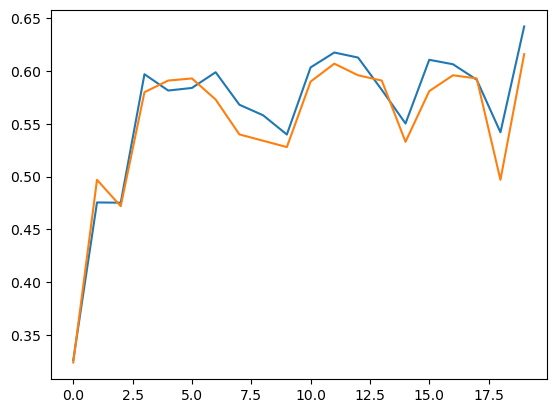

In [18]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [19]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 36.612242, Train accuracy: 0.282333, val accuracy: 0.292000
Loss: 32.145778, Train accuracy: 0.473667, val accuracy: 0.480000
Loss: 31.401500, Train accuracy: 0.543000, val accuracy: 0.555000
Loss: 42.119871, Train accuracy: 0.585333, val accuracy: 0.590000
Loss: 27.007428, Train accuracy: 0.616444, val accuracy: 0.601000
Loss: 42.478549, Train accuracy: 0.585000, val accuracy: 0.575000
Loss: 31.450078, Train accuracy: 0.601556, val accuracy: 0.603000
Loss: 38.768623, Train accuracy: 0.592667, val accuracy: 0.570000
Loss: 39.263463, Train accuracy: 0.595111, val accuracy: 0.590000
Loss: 39.864745, Train accuracy: 0.580000, val accuracy: 0.592000
Loss: 27.585063, Train accuracy: 0.650000, val accuracy: 0.624000
Loss: 36.458502, Train accuracy: 0.598111, val accuracy: 0.611000
Loss: 28.664251, Train accuracy: 0.599444, val accuracy: 0.588000
Loss: 33.889431, Train accuracy: 0.626778, val accuracy: 0.615000
Loss: 31.926195, Train accuracy: 0.580333, val accuracy: 0.554000
Loss: 38.2

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [20]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 43.004183, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.519144, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.994778, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.589914, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 40.785101, Train accuracy: 0.198333, val accuracy: 0.209000
Loss: 39.243259, Train accuracy: 0.245778, val accuracy: 0.247000
Loss: 38.520806, Train accuracy: 0.271111, val accuracy: 0.267000
Loss: 38.884111, Train accuracy: 0.294889, val accuracy: 0.301000
Loss: 36.030177, Train accuracy: 0.341444, val accuracy: 0.334000
Loss: 32.729296, Train accuracy: 0.388556, val accuracy: 0.387000
Loss: 33.488292, Train accuracy: 0.423333, val accuracy: 0.412000
Loss: 46.652439, Train accuracy: 0.456222, val accuracy: 0.450000
Loss: 44.932241, Train accuracy: 0.488111, val accuracy: 0.475000
Loss: 33.299336, Train accuracy: 0.515000, val accuracy: 0.494000
Loss: 35.313953, Train accuracy: 0.532000, val accuracy: 0.521000
Loss: 31.7

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [24]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.573018, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.515252, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.554951, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.469023, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.594011, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.383107, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.323683, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.312068, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.524668, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.231671, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.968402, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.257602, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.640635, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.843790, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.574396, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.0

Loss: 2.525189, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.580237, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.262550, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.782310, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.864887, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.702310, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.989709, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.344843, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.857049, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.926982, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.863847, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.791261, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.933580, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.922660, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.763234, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.879489, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [27]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.539045, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.559196, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.435784, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.213649, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.068871, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 9.226812, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.468180, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.710388, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 9.120015, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 6.937345, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 7.549810, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 5.891935, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 6.727748, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 2.912364, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 6.089984, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 5.559512, Trai

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [32]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2, 1e-3, 1e-4]
reg_strengths = [1e-2, 1e-3]
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 100
batch_sizes = [32, 64, 128]
# optimizers = []


best_classifier = None
best_val_accuracy = None

best_loss_history = []
best_train_history = []
best_val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above


for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for batch_size in batch_sizes:
            model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
            dataset = Dataset(train_X, train_y, val_X, val_y)
            trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size)

            loss_history, train_history, val_history = trainer.fit()
            
            if best_classifier is None:
                best_classifier = model
                best_val_accuracy = val_history[-1]
                best_loss_history = loss_history
                best_train_history = train_history
                best_val_history = val_history


            elif best_val_accuracy < val_history[-1]:
                
                best_classifier = model
                best_val_accuracy = val_history[-1]
                best_loss_history = loss_history
                best_train_history = train_history
                best_val_history = val_history

                

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: inf, Train accuracy: 0.090889, val accuracy: 0.115000
Loss: inf, Train accuracy: 0.114556, val accuracy: 0.116000
Loss: inf, Train accuracy: 0.138889, val accuracy: 0.138000
Loss: inf, Train accuracy: 0.084000, val accuracy: 0.091000
Loss: inf, Train accuracy: 0.151000, val accuracy: 0.151000
Loss: inf, Train accuracy: 0.072889, val accuracy: 0.075000
Loss: inf, Train accuracy: 0.103667, val accuracy: 0.121000
Loss: inf, Train accuracy: 0.096222, val accuracy: 0.089000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

KeyboardInterrupt: 

In [5]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 42.631909, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.010540, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.837910, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.927333, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.777970, Train accuracy: 0.206556, val accuracy: 0.215000
Loss: 44.741252, Train accuracy: 0.249000, val accuracy: 0.250000
Loss: 36.107144, Train accuracy: 0.274333, val accuracy: 0.271000
Loss: 40.941196, Train accuracy: 0.285222, val accuracy: 0.285000
Loss: 37.710616, Train accuracy: 0.339667, val accuracy: 0.343000
Loss: 38.412062, Train accuracy: 0.392111, val accuracy: 0.392000
Loss: 33.979941, Train accuracy: 0.430889, val accuracy: 0.408000
Loss: 32.453523, Train accuracy: 0.460556, val accuracy: 0.447000
Loss: 29.469344, Train accuracy: 0.487889, val accuracy: 0.475000
Loss: 30.352029, Train accuracy: 0.512667, val accuracy: 0.496000
Loss: 33.845693, Train accuracy: 0.539111, val accuracy: 0.532000
Loss: 30.9

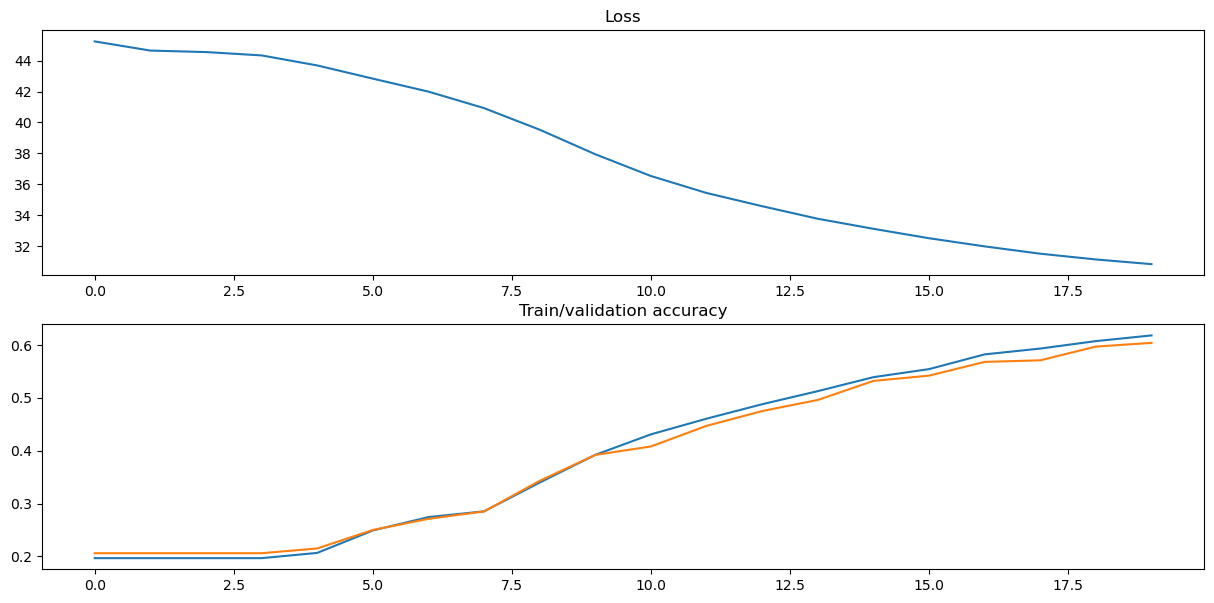

In [6]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [8]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.549000
